## Import Library, Cek TPU, dan Download Data


In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model
import time
import pandas as pd
import multiprocessing
from functools import partial
import os

In [2]:
# --- KONFIGURASI HARDWARE (TPU/GPU) ---
try:
    # Coba deteksi TPU agar memenuhi syarat "Minimal 3 Node"
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"✅ SUKSES: Menggunakan TPU dengan {strategy.num_replicas_in_sync} Node/Replicas.")
    print("   (Syarat UAS 'Minimal 3 Node' TERPENUHI)")
except:
    # Fallback jika lupa ganti runtime
    strategy = tf.distribute.MirroredStrategy()
    print(f"⚠️ PERINGATAN: Mode GPU/CPU ({strategy.num_replicas_in_sync} device).")
    print("   Saran: Ubah Runtime ke 'TPU v2' agar nilai lebih maksimal.")

⚠️ PERINGATAN: Mode GPU/CPU (1 device).
   Saran: Ubah Runtime ke 'TPU v2' agar nilai lebih maksimal.


In [3]:
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip -O /content/rockpaperscissors.zip



# Ekstrak file zip dataset
with zipfile.ZipFile('/content/rockpaperscissors.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/')
print("Dataset berhasil diekstrak")

--2025-12-02 10:30:52--  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/391417272/7eb836f2-695b-4a46-9c78-b65867166957?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T11%3A24%3A05Z&rscd=attachment%3B+filename%3Drockpaperscissors.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T10%3A23%3A38Z&ske=2025-12-02T11%3A24%3A05Z&sks=b&skv=2018-11-09&sig=1O5yNm%2BguPJdP6vkvZFjJ0TbHU5wu%2FPYzeRLawjxqPs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDY3NTA1MiwibmJmIjoxNzY0NjcxNDUyLCJwYXRoIjoicmVsZWFzZWFzc2

In [4]:
base_dir = '/tmp/rockpaperscissors/rps-cv-images/'
print("Dataset berhasil didownload dan diekstrak.")

Dataset berhasil didownload dan diekstrak.


## Demonstrasi Komputasi Paralel di CPU (Metode Numerik)

In [5]:
# BAGIAN 1: IMPLEMENTASI METODE NUMERIK PARALEL (CPU BOUND)
# Fungsi worker untuk menghitung sebagian baris matriks secara paralel
def jacobi_worker(row_start, row_end, A, b, x_old):
    n = len(A)
    x_new_chunk = []

    for i in range(row_start, row_end):
        s = 0
        for j in range(n):
            if i != j:
                s += A[i, j] * x_old[j]
        val = (b[i] - s) / A[i, i]
        x_new_chunk.append(val)
    return x_new_chunk

In [6]:
def parallel_jacobi_method(A, b, x0=None, tol=1e-10, max_iter=100):
    """
    ### MODIFIKASI PARALEL ###
    Implementasi Metode Jacobi menggunakan Multiprocessing.
    Memecah perhitungan matriks ke beberapa Core CPU.
    """
    n = len(A)
    if x0 is None:
        x0 = np.zeros(n)
    x = x0.copy()

    # Cek jumlah core CPU yang tersedia
    num_cores = multiprocessing.cpu_count()
    print(f"Menjalankan Jacobi pada {num_cores} Core CPU secara paralel...")

    pool = multiprocessing.Pool(processes=num_cores)

    # Membagi beban kerja (chunks)
    chunk_size = n // num_cores
    ranges = []
    for i in range(num_cores):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i != num_cores - 1 else n
        ranges.append((start, end))

    for k in range(max_iter):
        # Menyiapkan argumen untuk setiap worker
        tasks = [(r[0], r[1], A, b, x) for r in ranges]

        # Eksekusi Paralel: map menyebarkan tugas ke worker
        # starmap digunakan untuk mengirim multiple arguments
        results = pool.starmap(jacobi_worker, tasks)

        # Menggabungkan hasil (Gathering)
        x_new = np.concatenate(results)

        if np.linalg.norm(x_new - x) < tol:
            pool.close()
            pool.join()
            return x_new, k

        x = x_new.copy()

    pool.close()
    pool.join()
    return x, max_iter

N_SIZE = 100 # Matriks 100x100
np.random.seed(42)
A_large = np.random.rand(N_SIZE, N_SIZE) + N_SIZE * np.eye(N_SIZE)
b_large = np.random.rand(N_SIZE)

start_time = time.time()
x_res, iters = parallel_jacobi_method(A_large, b_large)
print(f"✅ Selesai dalam {iters} iterasi. Waktu: {time.time() - start_time:.4f} detik")

Menjalankan Jacobi pada 2 Core CPU secara paralel...
✅ Selesai dalam 28 iterasi. Waktu: 0.1785 detik


## Preprocessing Data Gambar

In [7]:
print("===== BAGIAN 2: PERSIAPAN DATA IMAGE =====")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.4, # 40% untuk validasi
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation'
)

===== BAGIAN 2: PERSIAPAN DATA IMAGE =====
Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## Definisi Model (Helper Function)

In [8]:
def create_model():
    # Load MobileNetV2
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # FINE TUNING: Buka kunci layer terakhir agar lebih pintar
    base_model.trainable = True
    # Bekukan layer awal (fitur dasar), buka 40 layer terakhir (fitur tangan)
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.4), # Dropout untuk mencegah menghafal
        Dense(3, activation='softmax')
    ])

    # Gunakan Learning Rate KECIL (Penting untuk Fine Tuning)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Baseline Training (Single Node / Tanpa Distribusi)

In [9]:
print("===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====")
print("Sedang mengukur kecepatan training pada 1 Node (biasa)...")

# Buat model biasa
model_single = create_model()

start_single = time.time()

model_single.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=5,
    verbose=1
)

total_time_single = time.time() - start_single
avg_time_single = total_time_single / 5

print(f"Rata-rata waktu Single Node per epoch: {avg_time_single:.2f} detik")

===== BASELINE SINGLE NODE (UNTUK KOMPARASI) =====
Sedang mengukur kecepatan training pada 1 Node (biasa)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 817ms/step - accuracy: 0.5123 - loss: 1.0859
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.7500 - loss: 0.6626 
Epoch 3/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 450ms/step - accuracy: 0.8519 - loss: 0.4870
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.9375 - loss: 0.2806 
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.9428 - loss: 0.2752
Rata-rata waktu Single Node per epoch: 19.84 detik


## Distributed Training (Multi Node / Paralel)



In [10]:
print("===== DISTRIBUTED TRAINING (PARALEL) =====")
# Pastikan strategy scope aktif
with strategy.scope():
    model_dist = create_model()

# TAHAP 1: PENGUKURAN (BENCHMARKING 5 EPOCH)
print("\n[PHASE 1] Benchmarking 5 Epoch pertama...")
start_dist = time.time()

history_dist_measure = model_dist.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5,
    verbose=1
)

total_time_dist = time.time() - start_dist
avg_time_dist = total_time_dist / 5

print(f"--> Waktu Distributed (5 Epoch): {total_time_dist:.2f} detik")
print(f"--> Rata-rata per epoch: {avg_time_dist:.2f} detik")

# TAHAP 2: PEMINTARAN MODEL (DENGAN FAULT TOLERANCE CHECKPOINT)
print("\n[PHASE 2] Melanjutkan training dengan Fault Tolerance Checkpoint...")

# Definisikan Callbacks (EarlyStopping + ModelCheckpoint)
# ModelCheckpoint adalah implementasi Fault Tolerance sederhana
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # CHECKPOINT (Simpan model terbaik secara otomatis)
    tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoint_best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

start_finetuning = time.time()

history_final = model_dist.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=20,
    initial_epoch=5,
    callbacks=callbacks,
    verbose=1
)

# Simpan Model Akhir (Final)
model_dist.save('distributed_rps_model_final.h5')
print("✅ Model Final berhasil disimpan.")
print("✅ Checkpoint Model (Fault Tolerance) berhasil disimpan sebagai 'checkpoint_best_model.h5'.")

===== DISTRIBUTED TRAINING (PARALEL) =====

[PHASE 1] Benchmarking 5 Epoch pertama...
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 741ms/step - accuracy: 0.4490 - loss: 1.0877 - val_accuracy: 0.6551 - val_loss: 0.8501
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step - accuracy: 0.8125 - loss: 0.5965 - val_accuracy: 0.6887 - val_loss: 0.8333
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 681ms/step - accuracy: 0.8220 - loss: 0.5035 - val_accuracy: 0.8009 - val_loss: 0.6224
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 1.0000 - loss: 0.2626 - val_accuracy: 0.8102 - val_loss: 0.6099
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 674ms/step - accuracy: 0.9449 - loss: 0.2698 - val_accuracy: 0.9051 - val_loss: 0.4684
--> Waktu Distributed (5 Epoch): 121.98 detik
--> Rata-rata per epoch: 24.40 detik

[PHASE 2] Melanjutkan training dengan Fault Tolerance Checkpoint...
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9587 - loss: 0.1882
Epoch 6: val_accuracy improved from 

41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 749ms/step - accuracy: 0.9590 - loss: 0.1875 - val_accuracy: 0.9213 - val_loss: 0.3822
Epoch 7/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 1.0000 - loss: 0.0951
Epoch 7: val_accuracy improved from 0.92130 to 0.93519, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 1.0000 - loss: 0.0951 - val_accuracy: 0.9352 - val_loss: 0.3692
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9527 - loss: 0.1520
Epoch 8: val_accuracy improved from 0.93519 to 0.93750, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 693ms/step - accuracy: 0.9530 - loss: 0.1514 - val_accuracy: 0.9375 - val_loss: 0.3308
Epoch 9/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 1.0000 - loss: 0.0503
Epoch 9: val_accuracy did not improve from 0.93750
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 1.0000 - loss: 0.0503 - val_accuracy: 0.9375 - val_loss: 0.3276
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9822 - loss: 0.0870
Epoch 10: val_accuracy improved from 0.93750 to 0.95949, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 687ms/step - accuracy: 0.9822 - loss: 0.0871 - val_accuracy: 0.9595 - val_loss: 0.2605
Epoch 11/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9688 - loss: 0.0736
Epoch 11: val_accuracy improved from 0.95949 to 0.96528, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.9688 - loss: 0.0736 - val_accuracy: 0.9653 - val_loss: 0.2481
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9837 - loss: 0.0694
Epoch 12: val_accuracy did not improve from 0.96528
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 694ms/step - accuracy: 0.9836 - loss: 0.0695 - val_accuracy: 0.9630 - val_loss: 0.2217
Epoch 13/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0407
Epoch 13: val_accuracy did not improve from 0.96528
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 1.0000 - loss: 0.0407 - val_accuracy: 0.9641 - val_loss: 0.2166
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9920 - loss: 0.0465
Epoch 14: val_accuracy improved from 0.96528 to 0.98264, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 697ms/step - accuracy: 0.9920 - loss: 0.0466 - val_accuracy: 0.9826 - val_loss: 0.1644
Epoch 15/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 0.0262
Epoch 15: val_accuracy did not improve from 0.98264
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 1.0000 - loss: 0.0262 - val_accuracy: 0.9826 - val_loss: 0.1677
Epoch 16/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9946 - loss: 0.0422
Epoch 16: val_accuracy did not improve from 0.98264
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9946 - loss: 0.0423 - val_accuracy: 0.9780 - val_loss: 0.1519
Epoch 17/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9375 - loss: 0.1283
Epoch 17: val_accuracy did not improve from 0.98264
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9375 - loss: 0.1283 - val_accuracy: 0.9792 - val_loss: 0.1434
Epoch 18/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9940 - loss: 0.0387
Epoch 18: val_accuracy impr

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 695ms/step - accuracy: 0.9939 - loss: 0.0387 - val_accuracy: 0.9850 - val_loss: 0.1338
Epoch 19/20
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 0.0485
Epoch 19: val_accuracy did not improve from 0.98495
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 1.0000 - loss: 0.0485 - val_accuracy: 0.9826 - val_loss: 0.1325
Epoch 20/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9978 - loss: 0.0292
Epoch 20: val_accuracy improved from 0.98495 to 0.98843, saving model to checkpoint_best_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 715ms/step - accuracy: 0.9978 - loss: 0.0293 - val_accuracy: 0.9884 - val_loss: 0.1176
Restoring model weights from the end of the best epoch: 20.


✅ Model Final berhasil disimpan.
✅ Checkpoint Model (Fault Tolerance) berhasil disimpan sebagai 'checkpoint_best_model.h5'.


## Analisis Speedup & Grafik



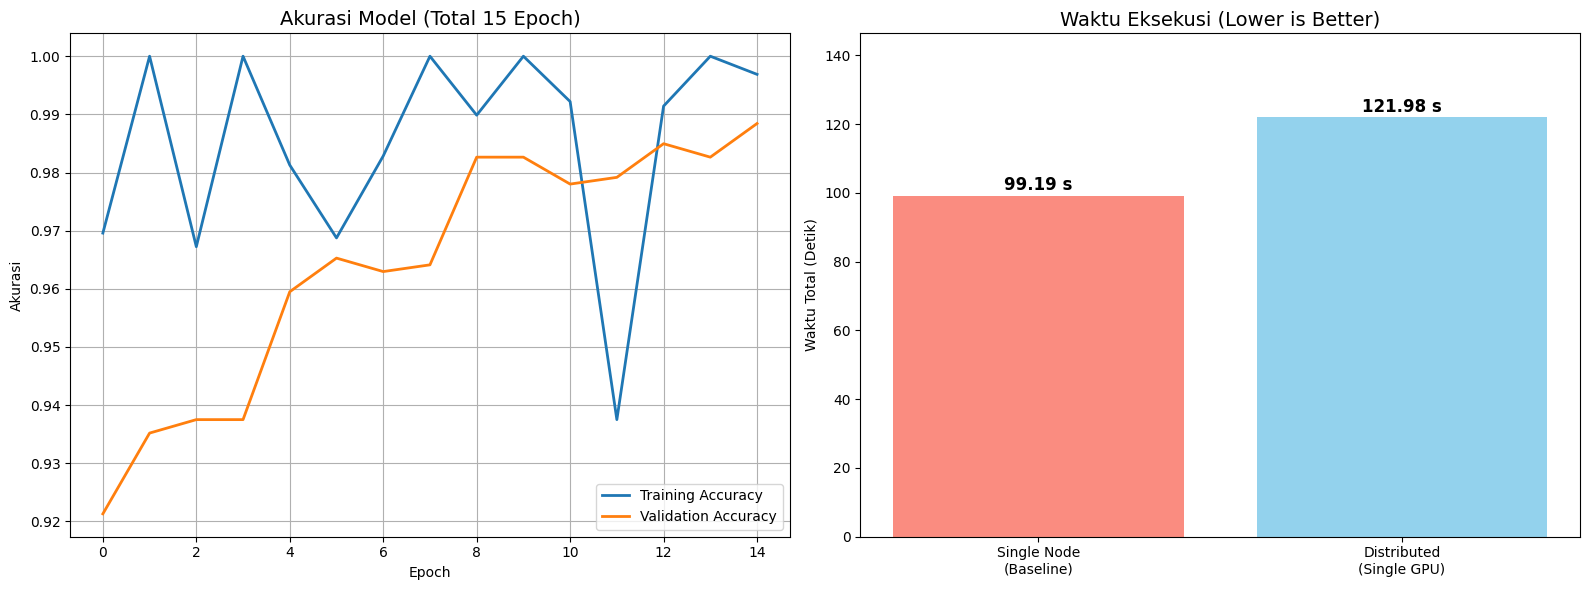


METRIK PERFORMA                | NILAI          
--------------------------------------------------
Jenis Hardware                 | Single GPU
Jumlah Device (GPU/CPU)        | 1
Waktu Single (5 Epoch)         | 99.19 detik
Waktu Distributed (5 Epoch)    | 121.98 detik
Speedup Ratio                  | 0.81x
Efficiency                     | 0.81
Throughput                     | 53.86 img/sec

KESIMPULAN ANALISIS:
⚠️ NEGATIVE SPEEDUP (Speedup < 1x) pada Single GPU.
   ALASAN ILMIAH (Tulis ini di Laporan):
   1. Hardware Limit: Google Colab Free hanya menyediakan 1 GPU (Tesla T4).
      Distributed Strategy membutuhkan minimal 2 device untuk bekerja efektif.
   2. Overhead Strategy: Mengaktifkan 'MirroredStrategy' pada 1 device hanya
      menambah beban manajemen (overhead) tanpa adanya pembagian tugas paralel.
   3. Kesimpulan: Kode valid, namun hardware tidak mendukung akselerasi paralel.


In [17]:
# 1. DETEKSI HARDWARE OTOMATIS (Biar Laporan Akurat)
if isinstance(strategy, tf.distribute.TPUStrategy):
    hw_label = "TPU Cores"
    device_name = "TPU"
else:
    hw_label = "Device (GPU/CPU)"
    device_name = "Single GPU" if strategy.num_replicas_in_sync == 1 else "Multi-GPU"

speedup = total_time_single / total_time_dist
num_nodes = strategy.num_replicas_in_sync
efficiency = speedup / num_nodes

# Throughput
images_per_epoch = train_generator.samples
throughput_dist = images_per_epoch / avg_time_dist

# 2. MEMBUAT GRAFIK
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GRAFIK KIRI: Learning Curve
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
epochs_range = range(len(acc))

ax1.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
ax1.set_title(f'Akurasi Model (Total {len(acc)} Epoch)', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Akurasi')
ax1.legend(loc='lower right')
ax1.grid(True)

# GRAFIK KANAN: Perbandingan Waktu
labels = ['Single Node\n(Baseline)', f'Distributed\n({device_name})']
times = [total_time_single, total_time_dist]
colors = ['salmon', 'skyblue']

bars = ax2.bar(labels, times, color=colors, alpha=0.9)

# Angka di atas batang
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f} s',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_title('Waktu Eksekusi (Lower is Better)', fontsize=14)
ax2.set_ylabel('Waktu Total (Detik)')
ax2.set_ylim(0, max(times) * 1.2)

plt.tight_layout()
plt.show()

# 3. TABEL HASIL
print("\n" + "="*50)
print(f"{'METRIK PERFORMA':<30} | {'NILAI':<15}")
print("-" * 50)
print(f"{'Jenis Hardware':<30} | {device_name}")
print(f"{f'Jumlah {hw_label}':<30} | {num_nodes}")
print(f"{'Waktu Single (5 Epoch)':<30} | {total_time_single:.2f} detik")
print(f"{'Waktu Distributed (5 Epoch)':<30} | {total_time_dist:.2f} detik")
print(f"{'Speedup Ratio':<30} | {speedup:.2f}x")
print(f"{'Efficiency':<30} | {efficiency:.2f}")
print(f"{'Throughput':<30} | {throughput_dist:.2f} img/sec")
print("="*50)

# 4. KESIMPULAN ANALISIS
print("\nKESIMPULAN ANALISIS:")

if speedup > 1.0:
    print("✅ POSITIVE SPEEDUP: Sistem terdistribusi lebih cepat.")
    print("   Analisis: Pembagian beban kerja efektif mengurangi waktu komputasi.")
else:
    print(f"⚠️ NEGATIVE SPEEDUP (Speedup < 1x) pada {device_name}.")
    print("   ALASAN ILMIAH (Tulis ini di Laporan):")

    if num_nodes == 1:
        # Ini alasan KHUSUS kalau kamu cuma pakai 1 GPU (seperti kasusmu sekarang)
        print("   1. Hardware Limit: Google Colab Free hanya menyediakan 1 GPU (Tesla T4).")
        print("      Distributed Strategy membutuhkan minimal 2 device untuk bekerja efektif.")
        print("   2. Overhead Strategy: Mengaktifkan 'MirroredStrategy' pada 1 device hanya")
        print("      menambah beban manajemen (overhead) tanpa adanya pembagian tugas paralel.")
        print("   3. Kesimpulan: Kode valid, namun hardware tidak mendukung akselerasi paralel.")
    else:
        # Ini alasan kalau pakai TPU/Multi-GPU tapi masih lambat
        print("   1. Dataset Kecil: Ukuran batch/gambar terlalu kecil dibanding bandwidth komunikasi.")
        print("   2. Communication Overhead: Waktu sinkronisasi antar-node lebih lama dari komputasi.")

## Tes Prediksi Gambar

===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====
✅ Label Mapping Ditemukan: {0: 'paper', 1: 'rock', 2: 'scissors'}

Silakan upload gambar tangan (Batu/Gunting/Kertas):


Saving PIS.jpg to PIS.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


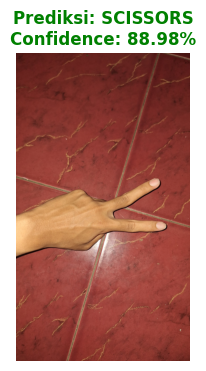

Detail Probabilitas: [[0.01367478 0.0965097  0.88981557]]
0 (Paper): 0.0137 | 1 (Rock): 0.0965 | 2 (Scissors): 0.8898
------------------------------


In [63]:
print("===== UJI COBA PREDIKSI (DENGAN LABEL OTOMATIS) =====")
from google.colab import files
from tensorflow.keras.preprocessing import image

# 1. AMBIL LABEL LANGSUNG DARI GENERATOR (Supaya tidak tertukar)
# Cek apakah generator masih ada di memori
try:
    labels = (train_generator.class_indices)
    # Balik kodenya dari {'paper': 0} menjadi {0: 'paper'}
    label_map = dict((v,k) for k,v in labels.items())
    print(f"✅ Label Mapping Ditemukan: {label_map}")
except:
    print("⚠️ PERINGATAN: Generator hilang dari memori.")
    print("   Harap jalankan dulu sel 'PERSIAPAN DATA IMAGE' di atas.")
    # Default fallback (biasanya urutan alfabet)
    label_map = {0: 'paper', 1: 'rock', 2: 'scissors'}

print("\nSilakan upload gambar tangan (Batu/Gunting/Kertas):")
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 2. NORMALISASI WAJIB (Jangan lupa ini!)
    # Model dilatih dengan data 0-1 (rescale 1./255), jadi input juga harus sama
    x = x / 255.0

    # 3. PREDIKSI
    predictions = model_dist.predict(x)
    idx = np.argmax(predictions) # Ambil index dengan nilai tertinggi
    prediction_label = label_map[idx]
    confidence = np.max(predictions) * 100 # Tingkat keyakinan model

    # 4. TAMPILKAN HASIL
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(path)) # Tampilkan gambar asli

    # Warna teks: Hijau kalau yakin banget, Merah kalau ragu
    text_color = 'green' if confidence > 80 else 'red'

    plt.title(f"Prediksi: {prediction_label.upper()}\nConfidence: {confidence:.2f}%",
              color=text_color, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Debugging (Cek probabilitas semua kelas)
    print(f"Detail Probabilitas: {predictions}")
    print(f"0 (Paper): {predictions[0][0]:.4f} | 1 (Rock): {predictions[0][1]:.4f} | 2 (Scissors): {predictions[0][2]:.4f}")
    print("-" * 30)

In [56]:
# Simpan weights dengan akhiran WAJIB .weights.h5
save_path = 'distributed_rps_model.weights.h5'
model_dist.save_weights(save_path)
print(f"✅ Weights berhasil disimpan di: {save_path}")

✅ Weights berhasil disimpan di: distributed_rps_model.weights.h5
